<a href="https://colab.research.google.com/github/YangxuanWu/Python/blob/master/Python/Project2020Fall/Project-Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
!ls

 all_data.csv  'Colab Notebooks'   CSVs


In [31]:
##1.  CICIDS2017 csv files are required for the operation of the program.
##  These files must be located under the "CSVs" folder in the same directory as the program.



##  The purpose of this program is to clear the csv files containing CICIDS2017 data from errors.
##  the faults observed are:
##      1-   288602 of the entries in the file "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv" are empty / meaningless.
##                   (e.g. ",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,")
##
##      2-  In the original csv files, while describing the Web Attack types such as Brute Force, XSS, Sql Injection, the character used is not recognized
##                    by the Python-Pandas library and leads to the error.
##                    this character ("–", Unicode code:8211) has been changed with another character ("-", Unicode code:45) to correct the error.
##
##   After the error correction, all the csv files were made into a single file (all_date.csv) to make it easier to process.

import pandas as pd
import os
from sklearn import preprocessing
import time
seconds = time.time()
%matplotlib inline

print("This process may take 5 to 10 minutes, depending on the performance of your computer.\n\n\n")
number="0123456789"
# CSV files names:
csv_files=["Monday-WorkingHours.pcap_ISCX",
        "Tuesday-WorkingHours.pcap_ISCX",
        "Wednesday-workingHours.pcap_ISCX",
        "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX",
        "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX",
        "Friday-WorkingHours-Morning.pcap_ISCX",
        "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX",
        "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX",]

# Headers of column
main_labels=["Flow ID","Source IP","Source Port","Destination IP","Destination Port","Protocol","Timestamp","Flow Duration","Total Fwd Packets",
   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","faulty-Fwd Header Length","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min","Idle Mean","Idle Std","Idle Max","Idle Min","Label","External IP"]

main_labels2=main_labels
main_labels=( ",".join( i for i in main_labels ) )
main_labels=main_labels+"\n"
flag=True
for i in range(len(csv_files)):
    ths = open(str(i)+".csv", "w")
    ths.write(main_labels)
    with open("./CSVs/"+csv_files[i]+".csv", "r") as file:
        while True:
            try:
                line=file.readline()
                if  line[0] in number:# this line eliminates the headers of CSV files and incomplete streams .
                    if " – " in str(line): ##  if there is "–" character ("–", Unicode code:8211) in the flow ,  it will be chanced with "-" character ( Unicode code:45).
                        line=(str(line).replace(" – "," - "))
                    ths.write(str(line))
                else:
                    continue                       
            except:
                break
    ths.close()
 
 
    df=pd.read_csv(str(i)+".csv",low_memory=False)
    df=df.fillna(0)

    string_features=["Flow Bytes/s","Flow Packets/s"]
    for ii in string_features: #Some data in the "Flow Bytes / s" and "Flow Packets / s" columns are not numeric. Fixing this bug in this loop
        df[ii]=df[ii].replace('Infinity', -1)
        df[ii]=df[ii].replace('NaN', 0)
        number_or_not=[]
        for iii in df[ii]:
            try:
                k=int(float(iii))
                number_or_not.append(int(k))
            except:
                number_or_not.append(iii)
        df[ii]=number_or_not



    string_features=[]
    for j in main_labels2: # In this section, non-numeric (string and / or categorical) properties (columns) are detected.
        if df[j].dtype=="object":
            string_features.append(j)
    try:
        string_features.remove('Label')#The "Label" property was removed from the list. Because it has to remain "categorical" for using with different machine learning approach.
    except:
        print("error!")
    labelencoder_X = preprocessing.LabelEncoder()



    for ii in string_features: ## In this loop, non-numeric (string and/or categorical) properties converted to numeric features.
        try:
            df[ii]=labelencoder_X.fit_transform(df[ii])
        except:
            df[ii]=df[ii].replace('Infinity', -1)
    df=df.drop(main_labels2[61], axis=1) ## Column 61 is deleted because it is unnecessary, column 41 ("Fwd Header Length" feature) had be mistakenly rewritten.



    ##All CSV files are merged into a single file.
    if flag:
        df.to_csv('all_data.csv' ,index = False)
        flag=False
    else:
        df.to_csv('all_data.csv' ,index = False,header=False,mode="a")
    os.remove(str(i)+".csv")
    print("The pre-processing phase of the ",csv_files[i]," file is completed.\n")
    

print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

This process may take 5 to 10 minutes, depending on the performance of your computer.



The pre-processing phase of the  Monday-WorkingHours.pcap_ISCX  file is completed.

The pre-processing phase of the  Tuesday-WorkingHours.pcap_ISCX  file is completed.

The pre-processing phase of the  Wednesday-workingHours.pcap_ISCX  file is completed.

The pre-processing phase of the  Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX  file is completed.

The pre-processing phase of the  Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX  file is completed.

The pre-processing phase of the  Friday-WorkingHours-Morning.pcap_ISCX  file is completed.

The pre-processing phase of the  Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX  file is completed.

The pre-processing phase of the  Friday-WorkingHours-Afternoon-DDos.pcap_ISCX  file is completed.

mission accomplished!
Total operation time: =  205.24071335792542 seconds


BENIGN              2203723
DoS Hulk             231073
PortScan             158930
DDoS                  41835
DoS GoldenEye         10293
FTP-Patator            7938
SSH-Patator            5897
DoS slowloris          5796
DoS Slowhttptest       5499
Bot                    1966
Infiltration             36
Heartbleed               11
Name: Label, dtype: int64


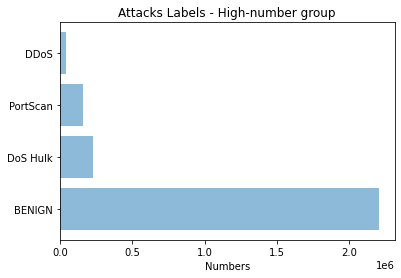

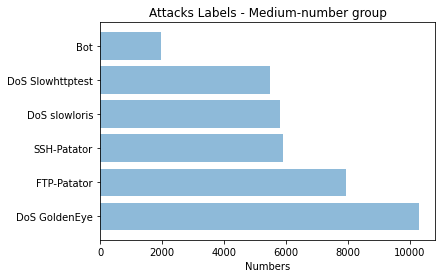

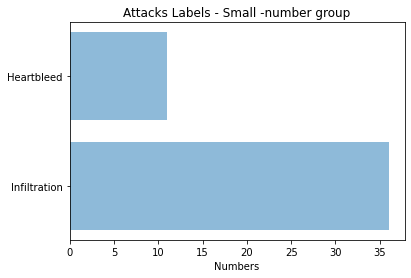

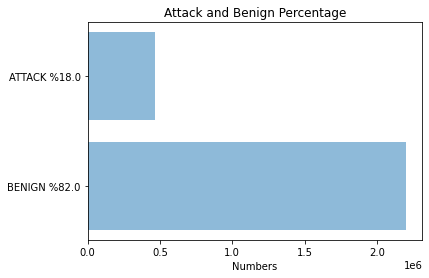

mission accomplished!
Total operation time: =  9.435401439666748 seconds


In [32]:
##2.  all_data.csv files is required for the operation of the program.
##  all_data.csv file must be located in the same directory as the program.



##  The purpose of this program is to provide statistics about the data contained in the dataset.
##  Considering that some of the data are very large and some of them are very small, the graphics are created in three separate groups, so that all data can be seen:
##          big: labels with more than 11000 numbers
##          medium: labels with numbers between 600 and 11000
##          small: labels with fewer than 600 numbers
##  
##  In the last graphics, the rates of all attacks and normal behaviors are given.



import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
%matplotlib inline
import time
seconds = time.time()

#  graph creation function
def graph(objects,performance,x_label,y_label):
    y_pos = np.arange(len(objects))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel(x_label)
    plt.title(y_label)
    plt.show()


df=pd.read_csv('all_data.csv', usecols=["Label"])
print(df.iloc[:,0].value_counts())
a=(df.iloc[:,0].value_counts())



key=a.keys()
values=a.values
small_labels=[]
small_values=[]
big_labels=[]
big_values=[]
medium_labels=[]
medium_values=[]
attacak=0
benign=0


## In this section, the attacks are grouped under 3 groups,
## so that all values can be seen on the graph.
for i in range(0,len(values)):
    if values[i]>11000:
        big_labels.append(str(key[i]))
        big_values.append(values[i])
    elif values[i]<600:
        small_labels.append(str(key[i]))
        small_values.append(values[i]) 
    else:
        medium_labels.append(str(key[i]))
        medium_values.append(values[i])

    if str(key[i])=="BENIGN":
        benign+=values[i]
    else:
        attacak+=values[i]
        
key =[benign,attacak]


#functions are called to create a chartes
labels=["BENIGN %"+str(round(benign/(benign+attacak),2)*100),
        "ATTACK %"+str(round(attacak/(benign+attacak),2)*100)]
graph(big_labels,big_values,"Numbers","Attacks Labels - High-number group")
graph(medium_labels,medium_values,"Numbers","Attacks Labels - Medium-number group")
graph(small_labels,small_values,"Numbers","Attacks Labels - Small -number group")
graph(labels,key,"Numbers","Attack and Benign Percentage")



print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

In [36]:
##3.all_data.csv file is required for the operation of the program.
##  all_data.csv file must be located in the same directory as the program.



##  The purpose of this program is to produce CSV files consisting of only one type of attack and benign flow.
##  These files contain all attack flow and some benign data flow. The rate : (attack= 30% , benign=70%)
##  normal data streams are randomly selected



import random
import os
import pandas as pd
import time
seconds = time.time()
%matplotlib inline

def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("Tthe folder could not be created!")
        


print("This process may take 3 to 8 minutes, depending on the performance of your computer.\n\n\n")




# Headers of column
main_labels=["Flow ID","Source IP","Source Port","Destination IP","Destination Port","Protocol","Timestamp","Flow Duration","Total Fwd Packets",
   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min","Idle Mean","Idle Std","Idle Max","Idle Min","Label","External IP"]
main_labels=( ",".join( i for i in main_labels ) )

attacks=["BENIGN", "Bot", "DDoS", "DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris", "FTP-Patator", "Heartbleed", "Infiltration", "PortScan", "SSH-Patator", "Web Attack – Brute Force", "Web Attack – Sql Injection", "Web Attack – XSS"]
folder("./attacks/")

benign=2359289

dict_attack={
"Bot":1966,
"DDoS":41835,
"DoS GoldenEye":10293,
"DoS Hulk":231073,
"DoS Slowhttptest":5499,
"DoS slowloris":5796,
"FTP-Patator":7938,
"Heartbleed":11,
"Infiltration":36,
"PortScan":158930,
"SSH-Patator":5897,
"Web Attack - Brute Force":1507,
"Web Attack - XSS":652,
"Web Attack - Sql Injection":21}



for i in dict_attack: # in this section, a file is opened for each attack type and is recorded at a random benign flow.
    a,b=0,0
    ths = open("./attacks/"+i + ".csv", "w")
    ths.write(str(main_labels)+"\n")
    benign_num=int(benign/(dict_attack[i]*(7/3)))
    with open("all_data.csv", "r") as file:
        while True:
            try:
                line=file.readline()
                line=line[:-1]
                k=line.split(",")
                if k[83]=="BENIGN":
                    rnd=random.randint(1,benign_num)
                    if rnd==1:
                            ths.write(str(line)+"\n")
                            b+=1
                if  k[83]==i:
                    ths.write(str(line)+"\n")
                    a+=1
                else:
                    continue                       
            except:
                break
    ths.close()
    print(i ,"file is completed\n attack:%d\n benign:%d\n\n\n " %(a,b))

    
##All web attack files are merged into a single file.
webs=["Web Attack - Brute Force","Web Attack - XSS","Web Attack - Sql Injection"]
flag=True
for i in webs:
    df=pd.read_csv("./attacks/"+str(i)+".csv")
    if flag:
        df.to_csv('./attacks/Web Attack.csv' ,index = False)
        flag=False
    else:
        df.to_csv('./attacks/Web Attack.csv' ,index = False,header=False,mode="a")
    os.remove("./attacks/"+str(i)+".csv")


print("mission accomplished!")
print("operation time: = ",time.time()- seconds ,"seconds")

This process may take 3 to 8 minutes, depending on the performance of your computer.



Bot file is completed
 attack:1966
 benign:4297


 
DDoS file is completed
 attack:41835
 benign:92128


 
DoS GoldenEye file is completed
 attack:10293
 benign:22495


 
DoS Hulk file is completed
 attack:231073
 benign:549682


 
DoS Slowhttptest file is completed
 attack:5499
 benign:12093


 
DoS slowloris file is completed
 attack:5796
 benign:12689


 
FTP-Patator file is completed
 attack:7938
 benign:17202


 
Heartbleed file is completed
 attack:11
 benign:32


 
Infiltration file is completed
 attack:36
 benign:79


 
PortScan file is completed
 attack:158930
 benign:367235


 
SSH-Patator file is completed
 attack:5897
 benign:12848


 
Web Attack - Brute Force file is completed
 attack:0
 benign:3296


 
Web Attack - XSS file is completed
 attack:0
 benign:1416


 
Web Attack - Sql Injection file is completed
 attack:0
 benign:43


 
mission accomplished!
operation time: =  217.334276437

In [53]:
##04-1 "attacks" folder (with attack csv files) is required for the operation of the program.
##  "attacks" folder must be located in the same directory as the program.


##  the purpose of this code is to determine which features to use in the machine learning phase.
##  for this purpose, the importance weights of the attacks are calculated.
##  this calculation was made using sklearn-RandomForestRegressor.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn as sk
import time
seconds = time.time()

def folder(f_name): #this function creates a folder named "feaure_pics" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        

# CSV files names:
csv_files=os.listdir("attacks")# It creates a list of file names in the "attacks" folder.

# Headers of column
main_labels=["Flow Duration","Total Fwd Packets",   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min",
    "Idle Mean","Idle Std","Idle Max", "Idle Min","Label"]

ths = open("importance_list_for_attack_files.csv", "w")
folder("./feaure_pics/")
for j in csv_files:
    df=pd.read_csv("./attacks/"+j,usecols=main_labels)
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]:#it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    y = df["Label"].values
    del df["Label"]
    X = df.values
   

    #computing the feature importances
    forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False).set_index('Features')
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    #printing the feature importances  
    count=0
    fea_ture=j[0:-4]+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(j[0:-4],"importance list:")
    print(j[0:-4],"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(j[0:-4]+" Attack - Feature Importance")
    plt.ylabel('Importance')
    plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
    ths.write((  fea_ture ) )
    plt.tight_layout()
    plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

    
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")
ths.close()

ValueError: ignored

In [35]:
##04-2  "all_data.csv" file is required for the operation of the program.
##  "all_data.csv" file must be located in the same directory as the program.


##  the purpose of this code is to determine which features to use in the machine learning phase.
##  for this purpose, the importance weights of the attacks are calculated.
##  this calculation was made using sklearn-RandomForestRegressor.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import sklearn as sk
import time
seconds = time.time()

def folder(f_name): #this function creates a folder named "feaure_pics" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        

# CSV files names:
csv_files=["all_data.csv"]# It creates a list of file names in the "attacks" folder.

# Headers of column
main_labels=["Flow Duration","Total Fwd Packets",   "Total Backward Packets","Total Length of Fwd Packets","Total Length of Bwd Packets","Fwd Packet Length Max","Fwd Packet Length Min",
   "Fwd Packet Length Mean","Fwd Packet Length Std","Bwd Packet Length Max","Bwd Packet Length Min","Bwd Packet Length Mean","Bwd Packet Length Std",
   "Flow Bytes/s","Flow Packets/s","Flow IAT Mean","Flow IAT Std","Flow IAT Max","Flow IAT Min","Fwd IAT Total","Fwd IAT Mean","Fwd IAT Std","Fwd IAT Max",
   "Fwd IAT Min","Bwd IAT Total","Bwd IAT Mean","Bwd IAT Std","Bwd IAT Max","Bwd IAT Min","Fwd PSH Flags","Bwd PSH Flags","Fwd URG Flags","Bwd URG Flags",
   "Fwd Header Length","Bwd Header Length","Fwd Packets/s","Bwd Packets/s","Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Std",
   "Packet Length Variance","FIN Flag Count","SYN Flag Count","RST Flag Count","PSH Flag Count","ACK Flag Count","URG Flag Count","CWE Flag Count",
   "ECE Flag Count","Down/Up Ratio","Average Packet Size","Avg Fwd Segment Size","Avg Bwd Segment Size","Fwd Avg Bytes/Bulk",
   "Fwd Avg Packets/Bulk","Fwd Avg Bulk Rate","Bwd Avg Bytes/Bulk","Bwd Avg Packets/Bulk","Bwd Avg Bulk Rate","Subflow Fwd Packets","Subflow Fwd Bytes",
   "Subflow Bwd Packets","Subflow Bwd Bytes","Init_Win_bytes_forward","Init_Win_bytes_backward","act_data_pkt_fwd",
   "min_seg_size_forward","Active Mean","Active Std","Active Max","Active Min",
    "Idle Mean","Idle Std","Idle Max", "Idle Min","Label"]

ths = open("importance_list_all_data.csv", "w")
folder("./feaure_pics/")
for j in csv_files:
    df=pd.read_csv(j,usecols=main_labels)
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]:#it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    y = df["Label"].values
    del df["Label"]
    X = df.values
   

    #computing the feature importances
    forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False).set_index('Features')
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    #printing the feature importances  
    count=0
    fea_ture=j[0:-4]+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(j[0:-4],"importance list:")
    print(j[0:-4],"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(j[0:-4]+" Attack - Feature Importance")
    plt.ylabel('Importance')
    plt.savefig("./feaure_pics/"+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
    ths.write((  fea_ture ) )
    plt.tight_layout()
    #plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

    
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"secomds")
ths.close()

ValueError: ignored

In [ ]:
##5.1  "all_data.csv" file is required for the operation of the program.
##  "all_data.csv" file must be located in the same directory as the program.

##  the purpose of this program is to apply machine learning algorithms to the dataset and observe the performance of algorithms.
##  the algorithms used are:Naive Bayes, QDA, Random Forest, ID3, AdaBoost, MLP, Nearest Neighbors
##  As the program display output data include: file name, machine learning algorithm name, accuracy,Precision, Recall, F1-score,Time
##  the program will create a CSV file that prints the results and a folder containing graphics.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org


from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")


result="./results/results_1.csv" #a CSV file is named in which the results are saved.
csv_files=os.listdir("attacks")# CSV files names: #The names of the files in the attacks folder are taken and assigned to a list (csv_files).
path=".\\attacks\\"
repetition=10


def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)
folder_name="./results/result_graph_1/"
folder(folder_name)


#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"Naive Bayes":GaussianNB(),
"QDA":QDA(),
"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy"),
"AdaBoost":AdaBoostClassifier(),
"MLP":MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500),
"Nearest Neighbors":KNeighborsClassifier(3)}



# the features to be used for each attack type is defined in a dictionary(features).
# the first 4 of the features created by the file "04_1_feature_selection_for_attack_files.py" are used here.
features={"Bot":["Bwd Packet Length Mean","Flow IAT Max","Flow Duration","Flow IAT Min","Label"],
"DDoS":["Bwd Packet Length Std","Total Backward Packets","Fwd IAT Total","Flow Duration","Label"],
"DoS GoldenEye":["Flow IAT Max","Bwd Packet Length Std","Flow IAT Min","Total Backward Packets","Label"],
"DoS Hulk":["Bwd Packet Length Std","Fwd Packet Length Std","Fwd Packet Length Max","Flow IAT Min","Label"],
"DoS Slowhttptest":["Flow IAT Mean","Fwd Packet Length Min","Bwd Packet Length Mean","Total Length of Bwd Packets","Label"],
"DoS slowloris":["Flow IAT Mean","Total Length of Bwd Packets","Bwd Packet Length Mean","Total Fwd Packets","Label"],
"FTP-Patator":["Fwd Packet Length Max","Fwd Packet Length Std","Fwd Packet Length Mean","Bwd Packet Length Std","Label"],
"Heartbleed":["Total Backward Packets","Fwd Packet Length Max","Flow IAT Min","Bwd Packet Length Max","Label"],
"Infiltration":["Fwd Packet Length Max","Fwd Packet Length Mean","Flow Duration","Total Length of Fwd Packets","Label"],
"PortScan":["Flow Bytes/s","Total Length of Fwd Packets","Fwd IAT Total","Flow Duration","Label"],
"SSH-Patator":["Fwd Packet Length Max","Flow Duration","Flow IAT Max","Total Length of Fwd Packets","Label"],
"Web Attack":["Bwd Packet Length Std","Total Length of Fwd Packets","Flow Bytes/s","Flow IAT Max","Label"]}

seconds=time.time()#time stamp for all processing time



with open(result, "w", newline="",encoding="utf-8") as f:#a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])




for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack files
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header
    a=[]
    
    feature_list=list(features[j[0:-4]])
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    
    y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    
    for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second=time.time()#time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y,#  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train,%20 test). 
                test_size = 0.20, random_state = repetition)#  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).


            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary                                                                          
            clf.fit(X_train, y_train)
            predict =clf.predict(X_test)
        
            #makes "classification report" and assigns the precision, f-measure, and recall values.s.    
                  
            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')

            
            
            
            
            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time()-second)) )


            
        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)), 
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file
        a.append(f1)


     # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feaure_graph folder.

     
    ml=["Naive Bayes","QDA","Random Forest","ID3","AdaBoost","MLP","Nearest Neighbors"]
    temp=0
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharey=True)
    for c in range(2):
        for b in range(4):
            axes[c, b].boxplot(a[temp] )
            axes[c, b].set_title(str(j[0:-4])+" - "+str(ml[temp]),fontsize=7)
            axes[c, b].set_ylabel(("F measure"))
            temp+=1
            if temp==7:
                break
        if temp==7:
            break
    plt.savefig(folder_name+j[0:-4]+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
    plt.show()
    print("\n------------------------------------------------------------------------------------------------------\n\n")
    
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

In [ ]:
##5.2  "all_data.csv" file is required for the operation of the program.
##  "all_data.csv" file must be located in the same directory as the program.

##  the purpose of this program is to apply machine learning algorithms to the dataset and observe the performance of algorithms.
##  the algorithms used are:Naive Bayes, QDA, Random Forest, ID3, AdaBoost, MLP, Nearest Neighbors
##  As the program display output data include: file name, machine learning algorithm name, accuracy,Precision, Recall, F1-score,Time
##  the program will create a CSV file that prints the results and a folder containing graphics.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org


from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score



            
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")


result="./results/results_2.csv" #a CSV file is named in which the results are saved.
csv_files=["all_data.csv"]# CSV files names: #The names of the dataset files (csv_files).
path=""
repetition=10


def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)
folder_name="./results/result_graph_2/"
folder(folder_name)


#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"Naive Bayes":GaussianNB(),
"QDA":QDA(),
"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy"),
"AdaBoost":AdaBoostClassifier(),
"MLP":MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500),
"Nearest Neighbors":KNeighborsClassifier(3)}



# the features to be used for each attack type is defined in a dictionary(features).
# the first 4 of the features created by the file "04_1_feature_selection_for_attack_files.py" are used here.
### The set of features to be used consists of combining the 4 features with the highest importance-weight achieved for each attack in approach 1 under a single roof.
### Thus, 4 features are obtained from each of the 12 attack types, resulting in a pool of features consisting of 48 attributes.
### After the repetitions are removed, the number of features is 18. The list of these features can be seen in below : ()

features={"all_data":["Bwd Packet Length Max","Bwd Packet Length Mean","Bwd Packet Length Std","Flow Bytes/s",
"Flow Duration","Flow IAT Max","Flow IAT Mean","Flow IAT Min","Flow IAT Std","Fwd IAT Total","Fwd Packet Length Max",
"Fwd Packet Length Mean","Fwd Packet Length Min","Fwd Packet Length Std","Total Backward Packets","Total Fwd Packets",
"Total Length of Bwd Packets","Total Length of Fwd Packets","Label"]}

seconds=time.time()#time stamp for all processing time






with open(result, "w", newline="",encoding="utf-8") as f:#a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])




for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack files
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header   
    feature_list=list(features[j[0:-4]])
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    
    y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    
    for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second=time.time()#time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y,#  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train,%20 test). 
                test_size = 0.20, random_state = repetition)#  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).


            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary                                                                          
            clf.fit(X_train, y_train)
            predict =clf.predict(X_test)
        
            #makes "classification report" and assigns the precision, f-measure, and recall values.s.    
            

            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')
            
            
            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time()-second)) )



            
        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)), 
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file
   
     # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feaure_graph folder.
        plt.boxplot(f1)
        plt.title("All Dataset - " +str(ii))
        plt.ylabel('F-measure')
        plt.savefig(folder_name+j[0:-4]+str(ii)+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
        plt.show()# you can remove the # sign if you want to see the graphics simultaneously

print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

In [ ]:
##5.3  "all_data.csv" file is required for the operation of the program.
##  "all_data.csv" file must be located in the same directory as the program.

##  the purpose of this program is to apply machine learning algorithms to the dataset and observe the performance of algorithms.
##  the algorithms used are:Naive Bayes, QDA, Random Forest, ID3, AdaBoost, MLP, Nearest Neighbors
##  As the program display output data include: file name, machine learning algorithm name, accuracy,Precision, Recall, F1-score,Time
##  the program will create a CSV file that prints the results and a folder containing graphics.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org


from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score




            
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")


result="./results/results_3.csv" #a CSV file is named in which the results are saved.
csv_files=["all_data.csv"]# CSV files names: #The names of the dataset files (csv_files).
path=""
repetition=10


def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)
folder_name="./results/result_graph_3/"
folder(folder_name)


#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"Naive Bayes":GaussianNB(),
"QDA":QDA(),
"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy"),
"AdaBoost":AdaBoostClassifier(),
"MLP":MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500),
"Nearest Neighbors":KNeighborsClassifier(3)}



#list of all columns to be imported
# the 7 features with the highest importance weight selected by the file "04_2_feature_selection_for_attack_files.py" are used here. (+ Label Feature)

features={"all_data":["Bwd Packet Length Std", "Flow Bytes/s", "Total Length of Fwd Packets", "Fwd Packet Length Std",
     "Flow IAT Std", "Flow IAT Min", "Fwd IAT Total","Label"]}

seconds=time.time()#time stamp for all processing time




with open(result, "w", newline="",encoding="utf-8") as f:#a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])




for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack files
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header   
    feature_list=list(features[j[0:-4]])
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    
    y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
    del df["Label"]
    feature_list.remove('Label')
    X = df[feature_list]

    
    for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second=time.time()#time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y,#  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train,%20 test). 
                test_size = 0.20, random_state = repetition)#  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).

            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary                                                                          
            clf.fit(X_train, y_train)
            predict =clf.predict(X_test)
        
            #makes "classification report" and assigns the precision, f-measure, and recall values.s.    
            
            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')

            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time()-second)) )


            
        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)), 
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file
   
     # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feaure_graph folder.
        plt.boxplot(f1)
        plt.title("All Dataset - " +str(ii))
        plt.ylabel('F-measure')
        plt.savefig(folder_name+j[0:-4]+str(ii)+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
        plt.show()# you can remove the # sign if you want to see the graphics simultaneously

print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

In [ ]:
##5.4  "all_data.csv" file is required for the operation of the program.
##  "all_data.csv" file must be located in the same directory as the program.

##  the purpose of this program is to apply machine learning algorithms to the dataset and observe the performance of algorithms.
##  the algorithms used are:Naive Bayes, QDA, Random Forest, ID3, AdaBoost, MLP, Nearest Neighbors
##  As the program display output data include: file name, machine learning algorithm name, accuracy,Precision, Recall, F1-score,Time
##  the program will create a CSV file that prints the results and a folder containing graphics.

##  the some codes parts used for calculation and graphing are taken from the following site.
##  http://scikit-learn.org


from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")



def folder(f_name): #this function creates a folder named "feaure_graph" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")
        

result="./results/results_Final.csv" #a CSV file is named in which the results are saved.
csv_files=["all_data.csv"]# CSV files names: #The names of the dataset files (csv_files).
path=""
repetition=10


def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="./results/"
folder(folder_name)
folder_name="./results/result_graph_Final/"
folder(folder_name)



# the 20 features selected by the file "04_2_feature_selection_for_attack_files.py" are used here. (+ Label Feature)
usecols=["Bwd Packet Length Std","Flow Bytes/s","Total Length of Fwd Packets","Fwd Packet Length Std","Flow IAT Std",
"Flow IAT Min","Fwd IAT Total","Flow Duration","Bwd Packet Length Max","Flow IAT Max","Flow IAT Mean","Total Length of Bwd Packets",
"Fwd Packet Length Min","Bwd Packet Length Mean","Flow Packets/s","Fwd Packet Length Mean","Total Backward Packets","Total Fwd Packets",
"Fwd Packet Length Max","Bwd Packet Length Min",'Label']




#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"Naive Bayes":GaussianNB(),
"QDA":QDA(),
"MLP":MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500),
"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy"),
"AdaBoost":AdaBoostClassifier(),
"Nearest Neighbors":KNeighborsClassifier(3)}




# the features to be used for Random Forest,ID3,AdaBoost,Nearest Neighbors is defined in a list(others).
# the first 7 of the features created by the file "04_2_feature_selection_for_attack_files.py" are used here.
others=["Bwd Packet Length Std", "Flow Bytes/s", "Total Length of Fwd Packets", "Fwd Packet Length Std",
     "Flow IAT Std", "Flow IAT Min", "Fwd IAT Total"]

#In this part different sets of properties for machine learning methods are defined as follows:
#For "Naive Bayes", "QDA", and "MLP", each method has a different feature list.
#other algorithms (Random Forest, ID3, AdaBoost, and Nearest Neighbors) use
#the first 7 of the features created by the file "04_2_feature_selection_for_attack_files.py" are used here.
algorithms_features={"Naive Bayes":['Bwd Packet Length Std', 'Total Length of Fwd Packets', 'Flow IAT Min', 'Fwd Packet Length Min', 'Flow Packets/s', 'Fwd Packet Length Mean'] ,
"QDA":['Bwd Packet Length Std', 'Flow Bytes/s', 'Total Length of Fwd Packets', 'Flow IAT Min'], 
"MLP":['Bwd Packet Length Std', 'Flow Bytes/s', 'Total Length of Fwd Packets', 'Fwd Packet Length Std',
'Flow IAT Min', 'Bwd Packet Length Max','Fwd Packet Length Min', 'Bwd Packet Length Mean',
'Total Backward Packets', 'Total Fwd Packets', 'Fwd Packet Length Max', 'Bwd Packet Length Min'],


#these algorithms use the features in the "others" list
"Random Forest":others,
"ID3" :others,
"AdaBoost":others,
"Nearest Neighbors":others}

seconds=time.time()#time stamp for all processing time




with open(result, "w", newline="",encoding="utf-8") as f:#a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])

for j in csv_files: #this loop runs on the list containing the filenames.Operations are repeated for all attack files
    print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % ("File","ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header
    feature_list=usecols
    df=pd.read_csv(path+j,usecols=feature_list)#read an attack file.
    df=df.fillna(0)
    attack_or_not=[]
    for i in df["Label"]: #it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        if i =="BENIGN":
            attack_or_not.append(1)
        else:
            attack_or_not.append(0)           
    df["Label"]=attack_or_not

    
    y = df["Label"] #this section separates the label and the data into two separate pieces, as Label=y Data=X 
    del df["Label"]
    feature_list.remove('Label')    
    for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        X = df[algorithms_features[ii]]
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second=time.time()#time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, y,#  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm. 
                test_size = 0.20, random_state = repetition)#  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).


            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary                                                                          
            clf.fit(X_train, y_train)
            predict =clf.predict(X_test)
        
            #makes "classification report" and assigns the precision, f-measure, and recall values.s.    
            

            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')

            

            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(clf.score(X_test, y_test))
            t_time.append(float((time.time()-second)) )


            
        print ('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' % (j[0:-4],ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)), 
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the avarage result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([j[0:-4],ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file



        # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feaure_graph folder.
        plt.boxplot(f1)
        plt.title("All Dataset - " +str(ii))
        plt.ylabel('F-measure')
        plt.savefig(folder_name+j[0:-4]+str(ii)+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
        plt.show()# you can remove the # sign if you want to see the graphics simultaneously
        
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")

In [ ]:
##5.4.2  "all_data.csv" file is required for the operation of the program.
##  "all_data.csv" file must be located in the same directory as the program.
##The intent of this program is to find the optimal property list for Naive Bayes, and QDA and MLP algorithms.
##It follows a kind of trial-and-error method.
##The feature list obtained from the file "04_2_feature_selection_for_attack_files.py" is placed in the machine learning algorithm to start with the highest importance score.
##If the F-measure for each feature is equal to or greater than the highest value obtained, this property is added to the list. Otherwise it is removed from the list.
##As a result of the process, the program gives the highest F-measure obtained and the property list that provides it
##




#%matplotlib inline
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score




            
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import time
seconds = time.time()


#list of all columns to be imported
# the 20 features selected by the file "04_2_feature_selection_for_attack_files.py" are used here. (+ Label Feature)
features=["Bwd Packet Length Std","Flow Bytes/s","Total Length of Fwd Packets","Fwd Packet Length Std",
"Flow IAT Std","Flow IAT Min","Fwd IAT Total","Flow Duration","Bwd Packet Length Max","Flow IAT Max",
"Flow IAT Mean","Total Length of Bwd Packets","Fwd Packet Length Min","Bwd Packet Length Mean",
"Flow Packets/s","Fwd Packet Length Mean","Total Backward Packets","Total Fwd Packets","Fwd Packet Length Max",
"Bwd Packet Length Min",'Label']
    
df=pd.read_csv('all_data.csv',usecols=features)#CSV rading



print ('%-17s %-17s ' % ("Feature Number","Feature"))# print output header
for i in range(len(features)-1):
    print ('%-17s %-17s' % (i+1,features[i]))# print features  and feature numbers 


print ('\n\n\n')

attack_or_not=[]
for i in df.iloc[:,-1]:
    if i =="BENIGN":#it changes the normal label to "1" and the attack tag to "0" for use in the machine learning algorithm
        attack_or_not.append(1)
    else:
        attack_or_not.append(0)
df.iloc[:,-1]=attack_or_not
y = df.iloc[:, -1].values #labes-y
my_list=[]


least=0



ml_list={#The machine learning algorithms to be used are defined in a dictionary (ml_list).
"Naive Bayes":GaussianNB(),
"QDA":QDA(),
##"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
##"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy"),
##"AdaBoost":AdaBoostClassifier(),
##"Nearest Neighbors":KNeighborsClassifier(3),
"MLP":MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)}


features.pop()#the Label tag is removed, no need any more
print ('%-17s %-30s %-10s  %-10s %-15s ' % ("ML algorithm","Feature Name","F1-score","Accuracy", "Feature List"))# print output header
for j in ml_list: # run for every machine learning.  
    my_list=[]
    for i in features: ## run for every  feature  
        my_list.append(i)
        X = df.loc[:, my_list].values # data

        ## cross-validation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
       
        #machine learning algorithm is applied in this section
        clf = ml_list[j]   #                                                                       
        clf.fit(X_train, y_train)
        predict =clf.predict(X_test)
        f1=clf.score(X_test, y_test)
        result=f1_score(y_test, predict, average='macro')
        accuracy=round(clf.score(X_test, y_test),2)
        temp="["
       
        for ii in my_list: 
            temp+=str(my_list.index(ii)+1)+", " #translate property list to sequence number for less space

       
        if result>=least:# If the F-criterion is equal to or greater than the highest value previously accessed, keep the new feature. 
            least=result
            print ('%-17s %-30s %-10s  %-10s %-15s %-15s ' % (j,i,result,accuracy ,temp, "------> New feature found!!!"))

        else:#If not, remove it from the list
            my_list.remove(my_list[len(my_list)-1])
            print ('%-17s %-30s %-10s  %-10s %-15s ' % (j,i,result,accuracy ,temp))
    print("F1=" ,least,j," The most efficient feature list =",my_list,"\n\n") #print maximum F1 and the most efficient feature list




print("mission accomplished!")
print("operation time: = ",time.time()- seconds ,"secomds")